# Packages

In [1]:
import numpy as np
import numpy.random as npr
import tensorflow as tf
from tensorflow import keras
from scipy.stats import norm
from keras.layers import Input, Dense, Concatenate
from keras.models import Model
from keras import backend as kb
import matplotlib.pyplot as plt
%run Neural_Networks.ipynb # Imports Neural Network
%run Simulation.ipynb # Imports Simulation to calculate MC price
plt.style.use('ggplot')

# Parameters

In [2]:
# Model parameters 
mu = 0.1
sigma = 0.3
S0 = 100
K = 100
r = 0.05
T = 30/365

# Simulation parameters
steps = 30
n_train = 100000
n_test = 10000
dt = T/steps

# Neural Network parameters
epochs = 10
learn_rate = 0.001
batch_size = 100
neurons = 200 # Number of neurons in hidden layers
n_hidden_layers = 3 # Number of hidden layers
n_inputs = 3 # time, logS_t, min(S_1,...,S_t)
n_outputs = 1 # delta

In [3]:
xi_train = npr.normal(0,np.sqrt(dt),(n_train,steps)) # Makes an (n x steps) matrix full of N(0,1/steps) realizations
W_train = np.apply_along_axis(np.cumsum,1,xi_train) # Cumulatively adds the realizations along each row
W_train = np.concatenate((np.zeros((n_train,1)),W_train),1) # Adds zeros in the first column of the matrix
drift = np.linspace(0,(mu-0.5*sigma**2)*T,steps+1) # Makes a (steps+1) length vector of equidistant values, ranging from 0 to mu
drift = np.reshape(drift,(1,steps+1)) # Converts the array into a matrix (with only 1 row)
drift_train = np.repeat(drift,n_train,axis=0) # Repeats the row n times
S_train = S0 * np.exp(drift_train + sigma * W_train) # Calculates S(t) at all timesteps and paths
dS_train = np.diff(S_train,1,1) # Calculates the change in S between each time point
time_grid = np.linspace(0,T,steps+1) # Time array

In [4]:
lookbackprice = MCprice_BS(option_type='lookback',n_paths=1000000)
lookbackprice

6.07471383042514

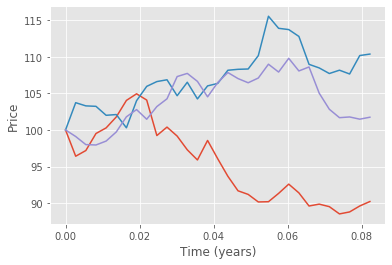

In [5]:
plt.plot(time_grid,S_train[0],time_grid,S_train[1],time_grid,S_train[2])
plt.xlabel("Time (years)")
plt.ylabel("Price")
plt.show()
#plt.savefig("BSpaths.png",dpi=500,bbox_inches="tight")

In [6]:
input_train = []
for i in range(steps):
    time_rep = np.repeat(time_grid[i],n_train)
    time_rep = np.reshape(time_rep,(n_train,1))
    logS_train = np.reshape(np.log(S_train[:,i])-np.log(S0),(n_train,1))
    cummin_train = np.reshape(np.log(np.minimum.accumulate(S_train,axis=-1)[:,i])-np.log(S0),(n_train,1))
    input_train.append(np.concatenate((time_rep,logS_train,cummin_train),1))

In [7]:
# 3 terms: Price of a call option, the value of the hedge portfolio, the payoff of the call option
def value_pf(y_true,y_pred):
    S = S0
    Vpf = lookbackprice
    B = Vpf - y_pred[:,0]*S
    for i in range(1,steps):
        S += y_true[:,i-1]
        Vpf = y_pred[:,i-1]*S+B*kb.exp(r*dt)
        B = Vpf - y_pred[:,i]*S
    S += y_true[:,-1]
    Vpf = y_pred[:,-1]*S+B*kb.exp(r*dt)
    return Vpf
        
def loss_lookback(y_true,y_pred):
    S = S0+kb.cumsum(y_true,axis=-1)
    minS = kb.minimum(kb.min(S,axis=-1),S0)
    return (value_pf(y_true,y_pred) - S[:,-1]+minS)**2

In [8]:
model = FFNN('sigmoid',n_inputs,n_outputs,loss_lookback, learn_rate,neurons,n_hidden_layers)

In [9]:
model.fit(input_train,dS_train,batch_size=batch_size,epochs=epochs)
#model.save('BS Lookback')
#model = tf.keras.models.load_model('BS Lookback', compile=False)

Epoch 1/10
1000/1000 [==============================] - 19s 16ms/step - loss: 1.3690
Epoch 2/10
1000/1000 [==============================] - 15s 15ms/step - loss: 0.7934
Epoch 3/10
1000/1000 [==============================] - 13s 13ms/step - loss: 0.7902
Epoch 4/10
1000/1000 [==============================] - 16s 16ms/step - loss: 0.7816
Epoch 5/10
1000/1000 [==============================] - 14s 14ms/step - loss: 0.7806
Epoch 6/10
1000/1000 [==============================] - 14s 14ms/step - loss: 0.7837
Epoch 7/10
1000/1000 [==============================] - 15s 15ms/step - loss: 0.7769
Epoch 8/10
1000/1000 [==============================] - 14s 14ms/step - loss: 0.7762
Epoch 9/10
1000/1000 [==============================] - 14s 14ms/step - loss: 0.7725
Epoch 10/10
1000/1000 [==============================] - 17s 17ms/step - loss: 0.7720


# Test

In [10]:
xi_test = npr.normal(0,np.sqrt(dt),(n_test,steps)) # Makes an (n x steps) matrix full of N(0,1/steps) realizations
W_test = np.apply_along_axis(np.cumsum,1,xi_test) # Cumulatively adds the realizations along each row
W_test = np.concatenate((np.zeros((n_test,1)),W_test),1) # Adds zeros in the first column of the matrix
drift = np.linspace(0,(mu-0.5*sigma**2)*T,steps+1) # Makes a (steps+1) length vector of equidistant values, ranging from 0 to mu
drift = np.reshape(drift,(1,steps+1)) # Converts the array into a matrix (with only 1 row)
drift_test = np.repeat(drift,n_test,axis=0) # Repeats the row n times
S_test = S0 * np.exp(drift_test + sigma * W_test) # Calculates S(t) at all timesteps and paths
dS_test = np.diff(S_test,1,1) # Calculates the change in S between each time point

In [11]:
input_test = []
for i in range(steps):
    time_rep = np.repeat(time_grid[i],n_test)
    time_rep = np.reshape(time_rep,(n_test,1))
    logS_test = np.reshape(np.log(S_test[:,i])-np.log(S0),(n_test,1))
    cummin_test = np.reshape(np.log(np.minimum.accumulate(S_test,axis=-1)[:,i])-np.log(S0),(n_test,1))
    input_test.append(np.concatenate((time_rep,logS_test,cummin_test),1))

In [12]:
delta_NN_test = model.predict(input_test)
Vpf_NN = lookbackprice
b = Vpf_NN - delta_NN_test[:,0]*S0
for i in range(1,steps):
    Vpf_NN = delta_NN_test[:,i-1]*S_test[:,i]+b*np.exp(r*dt)
    b = Vpf_NN - delta_NN_test[:,i]*S_test[:,i]
Vpf_NN = delta_NN_test[:,-1]*S_test[:,-1]+b*np.exp(r*dt)
Vpf_NN = np.array(Vpf_NN)

In [13]:
payoff_lookback = S_test[:,-1]-np.min(S_test,axis=-1)

In [14]:
PnL_NN = Vpf_NN - payoff_lookback
MSE_NN = np.sum(PnL_NN**2)/n_test

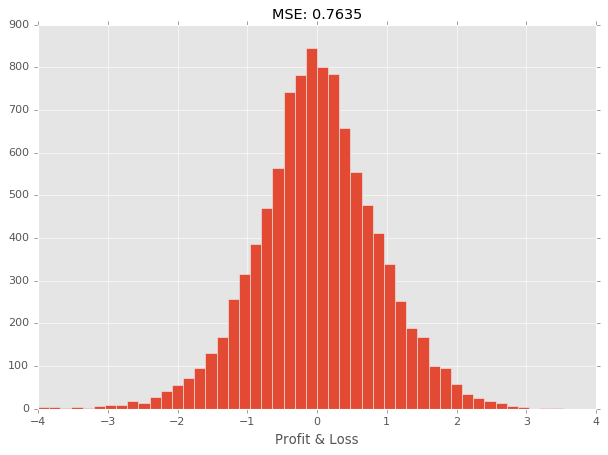

In [15]:
with plt.style.context(['classic', 'ggplot']):
    plt.figure(figsize=(9,6))
    plt.hist(PnL_NN, bins=50, range=(-4,4))
    plt.title(r'MSE: %1.4f' % MSE_NN, loc='center', fontsize=13)
    plt.xlabel("Profit & Loss")
    plt.ylim(0, 900)
plt.show()
#plt.savefig("BS_PnL_lookback_NN.png", dpi=500,bbox_inches="tight")

# Comparison with model delta

In [16]:
def delta_lookback(T,s,m):
    d1  = 1 / (sigma * np.sqrt(T)) * (np.log(s/m) + (r+sigma**2/2)*T)
    d2  = 1 / (sigma * np.sqrt(T)) * (np.log(m/s) + (r-sigma**2/2)*T)
    res = 1-(1+sigma**2/(2*r))*norm.cdf(-d1)+np.exp(-r*T)*(m/s)**(2*r/sigma**2)*(sigma**2/(2*r)-1)*norm.cdf(d2)
    return res
def price_lookback(t,s,m):
    d1 = 1 / (sigma * np.sqrt(T-t)) * (np.log(s/m) + (r+sigma**2/2)*(T-t))
    d2 = d1 - sigma * np.sqrt(T-t)
    d3 = -d1+(2*r*np.sqrt(T-t))/sigma
    term1 = s*norm.cdf(d1)
    term2 = -m*np.exp(-r*(T-t))*norm.cdf(d2)
    term3 = np.exp(-r*(T-t))*s*sigma**2/(2*r)*((m/s)**(2*r/sigma**2)*norm.cdf(d3)-np.exp(r*T)*norm.cdf(-d1))
    return (term1+term2+term3)

In [17]:
price_lookback(0,S0,S0)

6.873534693011253

In [18]:
lookbackprice

6.07471383042514

In [19]:
delta_lookback_test = []
Vpf_m = lookbackprice
a = delta_lookback(T,S0,S0)
b = Vpf_m - a*S0
for i in range(1,steps):
    Vpf_m = a*S_test[:,i]+b*np.exp(r*dt)
    a = delta_lookback(T-i*dt, S_test[:,i],np.minimum.accumulate(S_test,axis=-1)[:,i])
    b = Vpf_m - a*S_test[:,i]
Vpf_m = a*S_test[:,-1]+b*np.exp(r*dt) 

In [20]:
PnL_m = Vpf_m - payoff_lookback
MSE_m = np.sum(PnL_m**2)/n_test

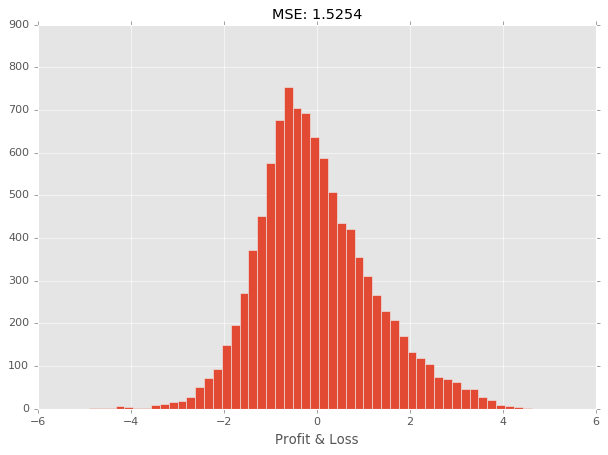

In [21]:
with plt.style.context(['classic', 'ggplot']):
    plt.figure(figsize=(9,6))
    plt.hist(PnL_m, bins=50)
    plt.title(r'MSE: %1.4f' % MSE_m, loc='center', fontsize=13)
    plt.xlabel("Profit & Loss")
    plt.ylim(0, 900)
plt.show()
#plt.savefig("BS_PnL_lookback_NN.png", dpi=500,bbox_inches="tight")

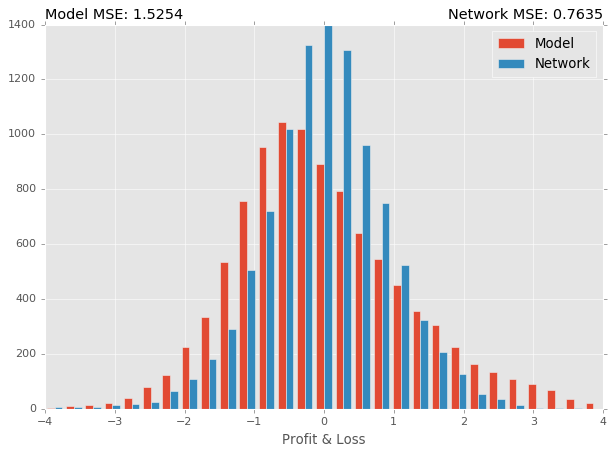

In [22]:
with plt.style.context(['classic','ggplot']):
    plt.figure(figsize=(9,6))
    bins = np.linspace(-4, 4, 30)
    plt.hist([PnL_m, PnL_NN], bins, label=['Model', 'Network'])
    plt.legend(loc='upper right')
    plt.xlabel("Profit & Loss")
    plt.title(r'Model MSE: %1.4f' % MSE_m, loc='left', fontsize=13)
    plt.title(r'Network MSE: %1.4f' % MSE_NN, loc='right', fontsize=13)
    plt.ylim(0, 1400)
plt.show()
#plt.savefig('PnL_lookback.png',dpi=500,bbox_inches="tight")